# Movie Recommendation Project

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import pdb
from sklearn import mixture
import matplotlib.pyplot as plt
import math
from itertools import permutations
import random
import sklearn.model_selection as model_selection
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error

## Import Data sets

In [49]:
allData = pd.read_csv('allData.tsv', sep='\t')
users = pd.read_csv('users.csv')

## Cleaning and adjusting data set

In [50]:
allData['genre'] = allData[allData.columns[6:9]].apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)
allData_temp = allData.sort_values(by=['userID']).drop(['genre1', 'genre2', 'genre3'], axis=1)
allData_new = allData_temp.drop('genre', axis=1).join(allData_temp['genre'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).rename('genre'))
allData_dummies = pd.get_dummies(allData_new, columns=['genre']).sort_values(by=['userID'])
allData_avg = allData_new.sort_values(by=['userID'])

In [51]:
allData_avg.head()

,userID,age,gender,movieID,name,year,rating,genre
14305,4,25,M,2245,Working Girl,1988,4,Drama
14305,4,25,M,2245,Working Girl,1988,4,Comedy
14306,4,25,M,2253,Toys,1992,1,Action
14306,4,25,M,2253,Toys,1992,1,Comedy
14306,4,25,M,2253,Toys,1992,1,Fantasy


In [52]:
# Selecting genres with the most observations
genretype_list_temp = allData_avg.sort_values(by=['genre']).genre.unique()
genretype_list = list()
genretype_list.append(genretype_list_temp[0])
genretype_list.append(genretype_list_temp[4])
genretype_list.append(genretype_list_temp[7])
genretype_list

['Action', 'Comedy', 'Drama']

In [53]:
def rating_avg():
    """
    Gets the average of all genres that a user has watched
    """
    genre_dict = {}
    for i in genretype_list[0:4]: #adjust to have columns we want
        values = []
        for j in users['userID']:
            values.append(allData_dummies.loc[(allData_avg['genre'] == i) & (allData_avg['userID'] == j), 'rating'].mean())
        genre_dict[i] = values
    return genre_dict

In [54]:
# Merge genre averages and users tables
genre_rating_avg = pd.DataFrame(rating_avg())
allData_df = pd.merge(users, genre_rating_avg, left_index=True, right_index=True)

In [55]:
allData_df.head()

,userID,age,gender,Action,Comedy,Drama
0,4,25,M,2.5,3.00,3.111111
1,5,56,M,NaN,4.25,4.200000
2,6,50,M,4.0,3.75,NaN
3,15,45,M,4.5,4.50,4.266667
4,17,25,F,2.5,NaN,5.000000


In [56]:
def genre_selection(genres, missing_genres):
    """
    Selects genres and sorts by value != NaN
    :type genres: List[str] # filled in genres
    :type missing_genres: List[str] # genre to impute
    :rtype: DataFrame
    """
    user_list = list()
    genre_list = allData_df.loc[:, genres].dropna()
    for i in genre_list.index.values:
        count = 0
        for j in missing_genres:
            if math.isnan(allData_df.loc[i, j]) == True:
                count += 1
            if count == len(missing_genres):
                user_list.append(i)
    return allData_df.loc[user_list, :]

In [57]:
users_new_ts = allData_df.copy()

In [58]:
def chunks(l, n):
    """
    Splits list into n amount of subsections
    :type l: List[]
    :type n: int
    """
    for i in range(0, len(l), n):
        yield l[i:i+n]

## Use Gaussian Mixture Model and Expectation-Maximization to impute users ratings

In [59]:
def impute(genres, missing_genres, n_components):
    """
    Imputes missing values using Gaussian Mixture Model (GMM) and Expectation-Maximization (EM) algorithm
    :type genres: List[str] # filled in genres
    :type missing_genres: List[str] # genre to impute
    :type n_components: int # arbitrary value
    :rtype: DataFrame
    """
    genre_sel = genre_selection(genres, missing_genres)
    genre_stk = []
    for i in genres:
        genre_stk.append(genre_sel[i].values.reshape(-1,1))
    train = np.vstack(genre_stk)
    #n_components = ?, whatever value that seems relevant to the data : this line can be removed if we are using a fixed n_components
    clf = mixture.GaussianMixture(n_components=n_components, covariance_type='full') # The GMM will iterate 100 times to find estimated values of the clusters
    groups = clf.fit_predict(train) # Fits the groups that were generated to each user
    group_list = list(chunks(groups, len(groups)//len(genres))) # splits the group array into x amount of genres   
    group_values = clf.fit(train).means_ # Gets values from each group
    group_dict = dict(zip(range(n_components), group_values))
    for chunk in range(len(group_list)):
        for idx, user in zip(range(len(genre_sel)), genre_sel.index.values): # gets individual indexes that correspond to the users in genre_sel
            for m_genre in missing_genres: # gets individual genres in missing_genres
                temp_group = group_list[chunk][idx] # saves the value found in groups to the corresponding user index
                users_new_ts.loc[user,m_genre] = group_dict[temp_group] # replaces the current nan value to the corresponding group value generated
    return users_new_ts

In [60]:
def fill(df):
    """
    :type df: DataFrame
    :rtype: DataFrame
    """
    impute(genres=['Action', 'Drama'], missing_genres=['Comedy'], n_components=5)
    impute(genres=['Action', 'Comedy'], missing_genres=['Drama'], n_components=5)
    impute(genres=['Drama', 'Comedy'], missing_genres=['Action'], n_components=5)
    impute(genres=['Action'], missing_genres=['Drama', 'Comedy'], n_components=5)
    impute(genres=['Drama'], missing_genres=['Action', 'Comedy'], n_components=5)
    imputed_df = impute(genres=['Comedy'], missing_genres=['Action', 'Drama'], n_components=5)
    return imputed_df

In [62]:
fill(users_new_ts).head()

,userID,age,gender,Action,Comedy,Drama
0,4,25,M,2.500000,3.000000,3.111111
1,5,56,M,3.945052,4.250000,4.200000
2,6,50,M,4.000000,3.750000,5.000000
3,15,45,M,4.500000,4.500000,4.266667
4,17,25,F,2.500000,4.970282,5.000000


## This data set is saved onto a Data Base file along with other tables

In [4]:
conn = sqlite3.connect("project.db")
c = conn.cursor()
c.execute("SELECT * FROM sqlite_master WHERE type='table'")

## Connect to data sets

In [112]:
df_movies_new = pd.read_sql("SELECT * FROM movies_new", conn) 
df_ts_vs = pd.read_sql("SELECT * FROM ts_vs", conn)
df_users_ts_vs = pd.read_sql("SELECT * FROM users_ts_vs ", conn)

In [65]:
df_users_ts_vs.head()

,Action_ar,Action_c,Adventure_ar,Adventure_c,Animation_ar,Animation_c,Children's_ar,Children's_c,Comedy_ar,Comedy_c,...,Thriller_ar,Thriller_c,War_ar,War_c,Western_ar,Western_c,age,gender,gender_c,userID
0,2.5,8,2.0,2,NaN,0,NaN,0,3.00,5,...,2.666667,3,NaN,0,NaN,0,25,M,None,4
1,NaN,0,NaN,0,NaN,0,NaN,0,4.25,4,...,NaN,0,NaN,0,NaN,0,56,M,None,5
2,4.0,5,4.0,1,NaN,0,3.0,1,3.75,4,...,4.000000,5,4.0,1,NaN,0,50,M,None,6
3,4.5,6,4.4,5,4.5,2,5.0,1,4.50,12,...,4.600000,10,4.5,2,NaN,0,45,M,None,15
4,2.5,4,NaN,0,NaN,0,3.0,1,NaN,0,...,4.000000,2,NaN,0,NaN,0,25,F,None,17


## Functions

In [66]:
def select_columns_users(df):
    """
    Selected columns, return a dataframe
    """
    return df[['Comedy_ar','Comedy_c','Drama_ar',
               'Drama_c','Action_ar','Action_c',
               'age','gender','userID']]

def select_columns_ratings(df):
    """
    Selected columns, return a dataframe
    """
    return df[['movieID','userID','rating']] 

def filter_NaN(df):
    """
    Drops NA values
    """
    return df.dropna()

def merge_ratings_users_new(ratings, filtered, movies_new):
    """
    Merge ratings dataframe, filtered new user dataframe and movies new dataframe
    into the final dataframe that is used to do regression
    """
    merge = ratings.merge(filtered, how = 'left', on = ['userID'])
    final = merge.merge(movies_new, how = 'left', on = ['movieID'])
    return final

def get_dummy_gender(df):
    """
    Create dummy variables for gender
    """
    return pd.get_dummies(df['gender'])

def get_aged(df):
    """
    Creates adjusted 'year' column
    """
    return 2019 - df['year']

def x_y(df):
    """
    Gets X variables and y variable
    """
    x = np.empty(24)
    y = np.empty(1)
    x = df[['Comedy_ar','Comedy_c','Drama_ar',
            'Drama_c','Action_ar','Action_c',
            'age','gender','Adventure',
            'Animation', "Children's",'Crime',
            'Documentary','Fantasy','Film-Noir',
            'Horror','Musical','Mystery',
            'Romance','Sci-Fi','Thriller',
            'War','Western','Aged']]
    y = df['rating']
    return x,y

def get_scores(linreg,x,y):
    """
    Gets linear regression score
    """
    scores = cross_validate(linreg, x, y, cv=10, scoring='neg_median_absolute_error', 
                            return_train_score=False)
    test_score = np.mean(-1*scores['test_score'])
    return test_score

def imputation_mean(df,ls_g):
    """
    take a users_new table, which as _ar and _c
    and a list of genres with missing value in _ar
    fill in the missing value with mean of the column
    return imputed data frame
    """
    df_filled = df.copy()
    for g in ls_g:
        df_filled[g+"_ar"] = df[g+"_ar"].fillna((df[g+"_ar"].mean()),inplace = False)
    return df_filled

## Linear regression for mean imputed data set

In [67]:
df_three_genres = select_columns_users(df_users_ts_vs)
df_final_ratings = select_columns_ratings (df_ts_vs)
df_mean_imputation = imputation_mean(df_three_genres,['Comedy','Drama','Action'])
df_final = merge_ratings_users_new(df_final_ratings, df_mean_imputation,df_movies_new)
df_final['gender'] = get_dummy_gender(df_final)
df_final['Aged'] = get_aged(df_final)

In [68]:
(x,y) = x_y(df_final)
x.head()

,Comedy_ar,Comedy_c,Drama_ar,Drama_c,Action_ar,Action_c,age,gender,Adventure,Animation,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Aged
0,3.562500,16,3.285714,7,3.000000,5,18,1,0,0,...,0,0,0,0,0,0,0,0,0,22
1,3.733333,30,3.769231,26,3.714286,21,25,0,0,0,...,0,0,0,0,0,0,1,0,0,24
2,3.956522,23,4.058824,17,4.250000,8,18,0,0,0,...,0,0,0,0,1,0,0,0,0,21
3,3.640000,50,3.744186,43,2.666667,18,25,0,0,0,...,0,0,0,0,0,0,0,0,0,29
4,3.363636,33,3.694444,36,3.333333,18,35,1,0,0,...,0,0,0,0,0,0,0,0,0,31


In [132]:
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
# model.summary()

## Linear Regression approach

In [70]:
linreg=LinearRegression(fit_intercept=False)
linreg.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [131]:
test_score = get_scores(linreg,x,y)
test_score

0.662636751726311

## Mean Imputation Prediction

In [72]:
df_test_set = pd.read_sql("SELECT * FROM test_set ", conn)
df_test_set_ratings = select_columns_ratings (df_test_set)
df_test_set_final = merge_ratings_users_new(df_test_set_ratings, df_mean_imputation,df_movies_new)
df_test_set_final['gender'] = get_dummy_gender(df_test_set_final)
df_test_set_final['Aged'] = get_aged(df_test_set_final)
(x_mean,y_mean) = x_y(df_test_set_final)

In [120]:
y_mean_predict = linreg.predict(x_mean)
mean_norm_ave = np.linalg.norm(y_mean - y_mean_predict)/300
print(mean_norm_ave); print(mean_absolute_error(y_mean, y_mean_predict))

0.06037899362875034
0.8161111533573069


## Linear Regression for GMM imputed data set

In [76]:
data = pd.read_csv("exported.csv")
data.head()

,Unnamed: 0,Action_ar,Action_c,Adventure_ar,Adventure_c,Animation_ar,Children's_ar,Children's_c,Comedy_ar,Comedy_c,...,Sci-Fi_c,Thriller_ar,Thriller_c,War_ar,War_c,Western_ar,Western_c,age,gender,userID
0,0,2.500000,8,2.0,2,NaN,NaN,0,3.000000,5,...,1,2.666667,3,NaN,0,NaN,0,25,M,4
1,1,2.157754,0,NaN,0,NaN,NaN,0,4.250000,4,...,0,NaN,0,NaN,0,NaN,0,56,M,5
2,2,4.000000,5,4.0,1,NaN,3.0,1,3.750000,4,...,0,4.000000,5,4.0,1,NaN,0,50,M,6
3,3,4.500000,6,4.4,5,4.5,5.0,1,4.500000,12,...,4,4.600000,10,4.5,2,NaN,0,45,M,15
4,4,2.500000,4,NaN,0,NaN,3.0,1,1.980624,0,...,4,4.000000,2,NaN,0,NaN,0,25,F,17


In [77]:
df_three_genres_GMM = select_columns_users(data)
df_mean_imputation_GMM = imputation_mean(df_three_genres_GMM,['Comedy','Drama','Action'])
df_final_GMM = merge_ratings_users_new(df_final_ratings, df_mean_imputation_GMM ,df_movies_new)
df_final_GMM['gender'] = get_dummy_gender(df_final_GMM)
df_final_GMM['Aged'] = get_aged(df_final_GMM)
(x_GMM,y_GMM) = x_y(df_final_GMM

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [ ]:
linreg_GMM=LinearRegression(fit_intercept=False)
linreg_GMM.fit(x_GMM,y_GMM)

In [121]:
test_score = get_scores(linreg_GMM,x_GMM,y_GMM)
test_score

0.6718658133239984

## GMM Imputation Prediction

In [122]:
df_test_set_final_GMM = merge_ratings_users_new(df_test_set_ratings, df_mean_imputation_GMM,df_movies_new)
df_test_set_final_GMM['gender'] = get_dummy_gender(df_test_set_final_GMM)
df_test_set_final_GMM['Aged'] = get_aged(df_test_set_final_GMM)
(x_mean_GMM,y_mean_GMM) = x_y(df_test_set_final_GMM)
y_mean_predict_GMM = linreg_GMM.predict(x_mean_GMM)
mean_norm_ave_GMM = np.linalg.norm(y_mean_GMM - y_mean_predict_GMM)/300
mean_norm_ave_GMM

0.05806345745169617

In [123]:
mean_absolute_error(y_mean_GMM, y_mean_predict_GMM)
diff_GMM = y_mean_predict_GMM - y_mean_GMM
diff_Mean = y_mean_predict - y_mean

## Compare performance of mean imputation and GMM

Text(0, 0.5, 'Predicted Values')

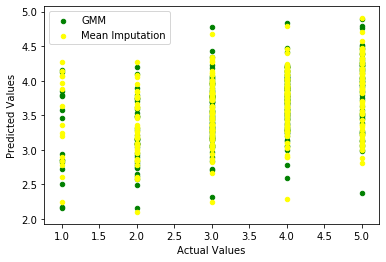

In [124]:
table_plot = {'Actual Values': y_mean_GMM, 
              'Predicted Values for GMM': y_mean_predict_GMM,
              'Error for GMM': diff_GMM,
              'Predicted Values for Mean Imputation': y_mean_predict,
             'Error for Mean Imputation': diff_Mean}
df_plot = pd.DataFrame(data=table_plot)
ax = df_plot.plot(kind="scatter", x="Actual Values",y="Predicted Values for GMM", color="green", 
                  label="GMM")
df_plot.plot( kind="scatter", x="Actual Values",y="Predicted Values for Mean Imputation", color="yellow", 
        label="Mean Imputation", ax = ax)
ax.set_xlabel("Actual Values")
ax.set_ylabel("Predicted Values")

Text(0, 0.5, 'Errors')

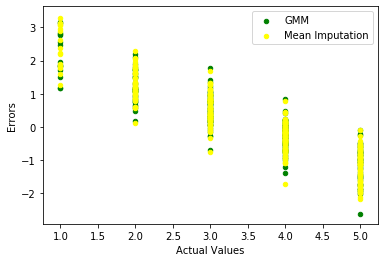

In [84]:
ax = df_plot.plot(kind="scatter", x="Actual Values",y="Error for GMM", color="green", 
                  label="GMM")
df_plot.plot( kind="scatter", x="Actual Values",y="Error for Mean Imputation", color="yellow", 
        label="Mean Imputation", ax = ax)
ax.set_xlabel("Actual Values")
ax.set_ylabel("Errors")

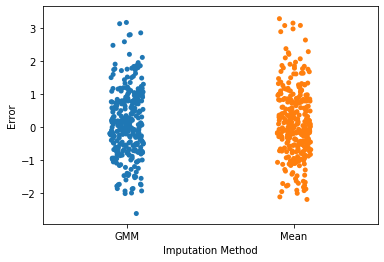

In [125]:
table_jitter_GMM = {'Error': diff_GMM,}
df_jitter_GMM = pd.DataFrame(data=table_jitter_GMM)
df_jitter_GMM['Imputation Method'] = 'GMM'
table_jitter_Mean = {'Error': diff_Mean}
df_jitter_Mean = pd.DataFrame(data=table_jitter_Mean)
df_jitter_Mean['Imputation Method'] = 'Mean'
df_jitter = df_jitter_GMM.merge(df_jitter_Mean, how = 'outer', 
                                on = ['Imputation Method','Error' ])
ax = sns.stripplot(x="Imputation Method", y="Error", data=df_jitter, jitter=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x1d3deeef4e0>,
 'caps': [<matplotlib.lines.Line2D at 0x1d3dfbe1e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d3deeef9e8>],
 'medians': [<matplotlib.lines.Line2D at 0x1d3dfbe1e48>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d3df7de668>],
 'means': []}

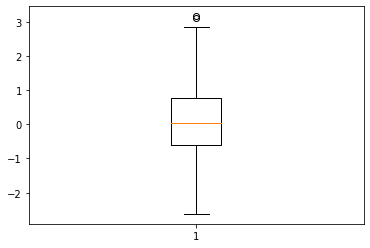

In [126]:
plt.boxplot(x = 'Error', data=df_jitter_GMM)

{'whiskers': [<matplotlib.lines.Line2D at 0x1d3df920d30>,
 'caps': [<matplotlib.lines.Line2D at 0x1d3df779f60>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d3df920cc0>],
 'medians': [<matplotlib.lines.Line2D at 0x1d3df779828>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d3dff9cb70>],
 'means': []}

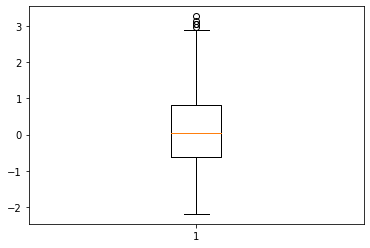

In [127]:
plt.boxplot(x = 'Error', data=df_jitter_Mean)

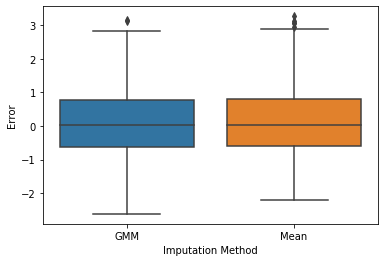

In [128]:
sns.boxplot(x='Imputation Method',y='Error',data=df_jitter)

In [91]:
def sep_testSet(df,testset_size):
    """
    seperate test set from original data, seperate a random set of given size
    return the test set and the rest of data (shuffled and reindexed)
    """
    if testset_size > df.shape[0]:
        raise Exception("test size size greater than size of df")
    else:
        df.reindex(np.random.permutation(df.index))
        df_shuffled = df.reindex(np.random.permutation(df.index))
        return df_shuffled.head(testset_size).reset_index(drop=True),df_shuffled.tail(df.shape[0]-testset_size).reset_index(drop=True)

In [92]:
def sep_10fold_crossvalidation(df,ifold):
    """
    seperate validation set from training set for 10 fold cross validation
    ifold gives the corresponding validation set and the other 9 set as training set
    """
    fold = int(np.ceil(df.shape[0]/10))
    start = (ifold-1)*fold
    end = min(ifold*fold,df.shape[0])
    vs =  [i for i in range(start,end)]
    if start ==0:
        ts =  [i for i in range(end,df.shape[0])]
    elif end == df.shape[0]:
        ts = [i for i in range(0,start)]
    else:
        ts = [i for i in range(end,df.shape[0])] +[i for i in range(0,start)]
    
    
    return df[df.index.isin(ts)].reset_index(drop=True), df[df.index.isin(vs)].reset_index(drop=True)

In [95]:
def make_trainingset_byGenre(ts):
    """
    generate all_byGenre table using only information in the training set
    input training set df, return all_byGenre df
    """
    df_ts_byGenre = pd.DataFrame()
    for g in ("genre1","genre2","genre3"):
        df_ts_byGenre1=ts.loc[ts[g].notnull(),["userID","age","gender","movieID","name","year",g,"rating" ]]
        new_cols = {"userID":"userID","age":"age","gender":"gender",
                    "movieID":"movieID","name":"name","year":"year",
                    "genre1":"genre","genre2":"genre","genre3":"genre",
                    "rating":"rating"}
        df_ts_byGenre1.rename(columns=new_cols,inplace=True)
        df_ts_byGenre = df_ts_byGenre.append(df_ts_byGenre1,sort=True, ignore_index = True)
    return df_ts_byGenre

def make_users_new_cv(df_ts_byGenre):
    """
    make new table users_new using input df_ts_byGenre df that's from the training data
    w/ new variable indicating how many movies the user rated in each genre
    and the average score for each genre
    if none rated then ave_score = NaN
    return the user_new table, and a table describing the stats
    """
    lsGenre = ('Action', 'Adventure', 'Animation', 
               "Children's", 'Comedy', 'Crime', 
               'Documentary', 'Drama', 'Fantasy', 
               'Film-Noir', 'Horror', 'Musical', 
               'Mystery', 'Romance', 'Sci-Fi', 
               'Thriller', 'War', 'Western')

    #a template dictionary indicating new column names in users_new table, "_c" is count and "_ar" is average rating (the genre names are exactly they way they are saved in the original data)
    row = {"userID":None, "age":None, "gender_c":None, 
           'Action_c':0, 'Adventure_c':0, 'Animation_c':0, 
           "Children's_c":0, 'Comedy_c':0, 'Crime_c':0, 
           'Documentary_c':0, 'Drama_c':0, 'Fantasy_c':0, 
           'Film-Noir_c':0, 'Horror_c':0, 'Musical_c':0, 
           'Mystery_c':0, 'Romance_c':0, 'Sci-Fi_c':0, 
           'Thriller_c':0, 'War_c':0, 'Western_c':0,
           'Action_ar':None, 'Adventure_ar':None, 'Animation_ar':None, 
           "Children's_ar":None, 'Comedy_ar':None, 'Crime_ar':None, 
           'Documentary_ar':None, 'Drama_ar':None, 'Fantasy_ar':None, 
           'Film-Noir_ar':None, 'Horror_ar':None, 'Musical_ar':None, 
           'Mystery_ar':None, 'Romance_ar':None, 'Sci-Fi_ar':None, 
           'Thriller_ar':None, 'War_ar':None, 'Western_ar':None}
    # create an empty list, to save the rows we want in the new dataframe (currently a list of dict, will be converted later)
    all_Users=[]

    # select users table from database
    c.execute("select * from users")

    # for each row in fetchall (each user), save original data and find count and average rating using all_byGenre dataframe
    for user in c.fetchall(): 
        # make a copy of template dict
        new_row = row.copy()
        # save existing values for a user
        new_row["userID"] = user[0]
        new_row["age"] = user[1]
        new_row["gender"] = user[2]
        # loop through the 18 genre
        for g in lsGenre:      
            # find a subset of all_byGrenre table with the current userID and genre (g) and save in a temperary df
            df_temp = df_ts_byGenre[(df_ts_byGenre["userID"]==user[0]) & (df_ts_byGenre["genre"]==g) ]
            # count how many rating events are in the emperary df
            count = df_temp.shape[0]
            # if count is non-zero, then find average, save in dict
            if count != 0:
                new_row[g+"_ar"] = df_temp["rating"].mean()
            # save count in dict
            new_row[g+"_c"]=count
        # add current row (user) to list of dicts
        all_Users.append(new_row)
    # convert list of dicts to a dataframe
    users_new = pd.DataFrame(all_Users)
    
    gStats = []
    stats = {"genre":None,"%missing":None, "c_mean":None,
             "c_median":None,"c_std":None,"c_mean_nm":None,
             "c_median_nm":None,"c_std_nm":None,"ar_mean":None,
             "ar_median":None,"ar_std":None}
    for g in lsGenre:
        new_stats = stats.copy()
        new_stats["genre"]= g
        new_stats["c_mean"] = users_new[g+"_c"].mean()
        new_stats["c_median"] = users_new[g+"_c"].median()
        new_stats["c_std"] = users_new[g+"_c"].std()
        temp_nm = users_new[users_new[g+"_c"]!=0]
        new_stats["%missing"] = temp_nm.shape[0]/users_new.shape[0]
        new_stats["c_mean_nm"] = temp_nm[g+"_c"].mean()
        new_stats["c_median_nm"] = temp_nm[g+"_c"].median()
        new_stats["c_std_nm"] = temp_nm[g+"_c"].std()
        new_stats["ar_mean_nm"] = temp_nm[g+"_ar"].mean()
        new_stats["ar_median_nm"] = temp_nm[g+"_ar"].median()
        new_stats["ar_std_nm"] = temp_nm[g+"_ar"].std()
        gStats.append(new_stats)
    users_stats = pd.DataFrame(gStats)
        
    # add all_Users to database as a new table users_new
    # users_new.to_sql("users_new", conn, if_exists="replace", index=False)
    return users_new,users_stats

In [100]:
np.random.seed(100)
test_set, allworkingData = sep_testSet(allData,20)
training_set, validation_set = sep_10fold_crossvalidation(allworkingData,2)
users_new_ts, users_stats_ts = make_users_new_cv(make_trainingset_byGenre(training_set))

In [5]:
conn.close()